# 2025 CITS4012 Project
*Make sure you change the file name with your group id.*

In [77]:
import pandas as pd
import numpy as np
import sys
import os 
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import classification_report, confusion_matrix
import copy
import random

import nltk
if not nltk.download('punkt'):
    nltk.download('punkt')
    nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

if not nltk.download('stopwords'):
    nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

import re
import pandas as pd
import numpy as np

# Stemmer and Lemmatizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag, word_tokenize

if not nltk.download('wordnet'):
    nltk.download('wordnet')
    nltk.download('omw-1.4')
    nltk.download('averaged_perceptron_tagger')

sys.path.append(os.path.abspath('..')) 
import math


import torch
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

CUDA available: True
CUDA version: 12.4
Number of GPUs: 1
GPU name: NVIDIA GeForce RTX 3060


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Josh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Josh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Josh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [76]:
import time
import math

# Helper functions for training
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Readme

# 1.Dataset Processing


In [7]:
# Config
MIN_WORD_LENGTH = 3
MAX_WORD_LENGTH = 60 

# These are common English contractions.
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}


# Helper function for lemmatization with POS tagging
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun if no match
    
# Allowed POS tags for filtering (example: nouns, verbs, adjectives, adverbs)
allowed_pos_tags = {'NN', 'NNS', 'NNP', 'NNPS',   # Nouns
                    'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ',  # Verbs
                    'JJ', 'JJR', 'JJS',           # Adjectives
                    'RB', 'RBR', 'RBS'}           # Adverbs

# Filter the desired POS tags
def filter_tokens_by_pos(tokens):
    tagged_tokens = pos_tag(tokens)
    filtered = [word for word, tag in tagged_tokens if tag in allowed_pos_tags]
    return filtered

def clean_dataset(dataset, MIN_WORD_LENGTH=3, MAX_WORD_LENGTH=60, method=['stem, lemmatize'], pos_filter=False, stop_w=False):
    cleaned_premises = []
    cleaned_hypotheses = []
    cleaned_labels = []

    for index, row in dataset.iterrows():
        premise = row['premise']
        hypothesis = row['hypothesis']
        label = row['label']

        # Lowercase
        premise = premise.lower()
        hypothesis = hypothesis.lower()

        # Expand contractions
        for contraction, full_form in contraction_dict.items():
            premise = premise.replace(contraction, full_form)
            hypothesis = hypothesis.replace(contraction, full_form)

        # Remove punctuation/special chars
        premise = re.sub(r'[^\w\s]', '', premise)
        hypothesis = re.sub(r'[^\w\s]', '', hypothesis)

        # Replace underscores/hyphens with spaces, then normalize whitespace
        premise = re.sub(r'[-–—_]+', ' ', premise)
        hypothesis = re.sub(r'[-–—_]+', ' ', hypothesis)

        # Normalize whitespace
        premise = re.sub(r'\s+', ' ', premise).strip()
        hypothesis = re.sub(r'\s+', ' ', hypothesis).strip()


        # Normalize whitespace
        premise = re.sub(r'\s+', ' ', premise).strip()
        hypothesis = re.sub(r'\s+', ' ', hypothesis).strip()

        # Tokenization
        premise_tokens = word_tokenize(premise)
        hypothesis_tokens = word_tokenize(hypothesis)

        # Replace numbers with '<NUM>'
        premise_tokens = ['[NUM]' if any(char.isdigit() for char in word) else word for word in premise_tokens]
        hypothesis_tokens = ['[NUM]' if any(char.isdigit() for char in word) else word for word in hypothesis_tokens]


        # Stemming/Lemmatization
        if 'stem' in method:
            stemmer = PorterStemmer()
            premise_tokens = [stemmer.stem(word) for word in premise_tokens]
            hypothesis_tokens = [stemmer.stem(word) for word in hypothesis_tokens]
        elif 'lemmatize' in method:
            lemmatizer = WordNetLemmatizer()
            premise_pos_tags = pos_tag(premise_tokens)
            hypothesis_pos_tags = pos_tag(hypothesis_tokens)
            premise_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in premise_pos_tags]
            hypothesis_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in hypothesis_pos_tags]

        # POS Filtering
        if pos_filter:
            premise_tokens = filter_tokens_by_pos(premise_tokens)
            hypothesis_tokens = filter_tokens_by_pos(hypothesis_tokens)

        # Remove stop words
        if stop_w:
            premise_tokens = [word for word in premise_tokens if word not in stop_words]
            hypothesis_tokens = [word for word in hypothesis_tokens if word not in stop_words]

        # Now check token length AFTER cleaning
        if (MIN_WORD_LENGTH <= len(premise_tokens) <= MAX_WORD_LENGTH and
            MIN_WORD_LENGTH <= len(hypothesis_tokens) <= MAX_WORD_LENGTH):
            cleaned_premises.append(premise_tokens)
            cleaned_hypotheses.append(hypothesis_tokens)
            cleaned_labels.append(label)
        # else: skip row

    # Build DataFrame from all cleaned token lists
    new_dataset = pd.DataFrame({
        'premise': cleaned_premises,
        'hypothesis': cleaned_hypotheses,
        'label': cleaned_labels
    })

    return new_dataset

## 1.1 Make the Datasets

In [8]:
# Load raw data
train_df = pd.read_json('Dataset/train.json')
test_df = pd.read_json('Dataset/test.json')
validation_df = pd.read_json('Dataset/validation.json')

# Clean datasets. MAX_WORD_LENGTH set to 64 to remove very long texts
clean_train_dataset = clean_dataset(train_df, MIN_WORD_LENGTH=3, MAX_WORD_LENGTH=64, stop_w=True, method=[], pos_filter=False)
clean_test_dataset = clean_dataset(test_df, MIN_WORD_LENGTH=3, MAX_WORD_LENGTH=64,stop_w=True, method=[], pos_filter= False )
clean_validation_dataset = clean_dataset(validation_df, MIN_WORD_LENGTH=3, MAX_WORD_LENGTH=64,stop_w=True, method=[], pos_filter= False )

# Combine clean premises and hypotheses
clean_t_dataset = clean_train_dataset['premise'] + clean_train_dataset['hypothesis']
clean_t_dataset.head()

0    [pluto, rotates, axis, every, [NUM], earth, da...
1    [glenn, per, day, earth, rotates, axis, earth,...
2    [geysers, periodic, gush, hot, water, surface,...
3    [facts, liquid, water, droplets, changed, invi...
4    [comparison, earth, rotates, axis, per, day, r...
dtype: object

In [21]:
# Create a unique word list from the cleaned dataset
unique_words = set()
for sentence in clean_t_dataset: # Both Premise and Hypothesis 
    for word in sentence:
        unique_words.add(word)
        
unique_words_list = sorted(list(unique_words))

# Make dictionary of words and indices
word2id = {w:i for i,w in enumerate(unique_words_list)}
id2word = {i:w for i,w in enumerate(unique_words_list)}


# Add special tokens to use later
SPECIAL_TOKENS = ['[PAD]','[UNK]','[CLS]','[SEP]'] # And [NUM] added during cleaning
for tok in SPECIAL_TOKENS:
    if tok not in word2id:
        idx = len(word2id)
        word2id[tok] = idx
        id2word[idx] = tok

VOCAB_SIZE = len(word2id)
print(f"Vocab size (including special tokens): {VOCAB_SIZE}")

Vocab size (including special tokens): 20842


In [60]:
def prepare_indexed_data(df, word2id, max_len):
    input_ids = []
    attention_mask = []
    labels = []

    label_map = {'neutral': 0, 'entails': 1}

    for _, row in df.iterrows():
        premise_toks = row['premise']
        hypothesis_toks = row['hypothesis']
        label = row['label']

        # Add special tokens 
        tokens = [word2id['[CLS]']] \
                + [word2id.get(w,word2id['[UNK]']) for w in premise_toks] \
                + [word2id['[SEP]']] \
                + [word2id.get(w,word2id['[UNK]']) for w in hypothesis_toks] 
        # Truncate
        tokens = tokens[:max_len]

        # Attention mask 
        attn = [1] * len(tokens)

        # Pad
        pad_len = max_len- len(tokens) # To fill the [PAD]
        if pad_len > 0:
            tokens += [word2id['[PAD]']] * pad_len
            attn += [0] * pad_len # FLag positions as padding 

        input_ids.append(tokens)
        attention_mask.append(attn)
        labels.append(label_map[label])

    return (torch.LongTensor(input_ids),
            torch.LongTensor(attention_mask),
            torch.LongTensor(labels))

Shape of x_train: torch.Size([22621, 64])
Shape of train_masks: torch.Size([22621, 64])
Shape of y_train: torch.Size([22621])

--- Example ---
First example real length (mask sum): 15
First example PAD count: 49


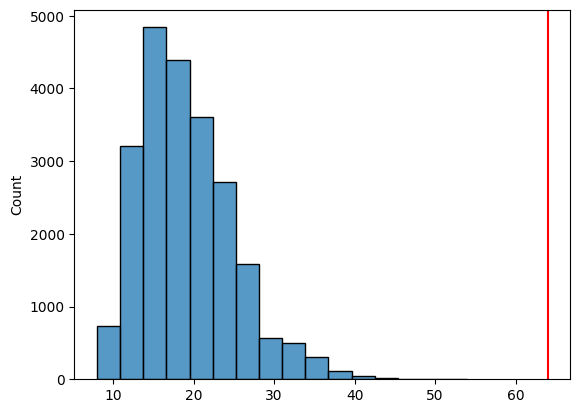

In [ ]:
MAX_SEQ_LEN = 64
#embedding_size

# Build train/test
x_train, train_masks, y_train = prepare_indexed_data(clean_train_dataset, word2id, MAX_SEQ_LEN)
x_test,  test_masks,  y_test  = prepare_indexed_data(clean_test_dataset,  word2id, MAX_SEQ_LEN)
x_valid,  valid_masks,  y_valid  = prepare_indexed_data(clean_validation_dataset,  word2id, MAX_SEQ_LEN)

print("Shape of x_train:", x_train.shape)
print("Shape of train_masks:", train_masks.shape)
print("Shape of y_train:", y_train.shape)

# Sanity Check 
i = 0
print("\n--- Example ---")
print("First example real length (mask sum):", int(train_masks[i].sum()))
print("First example PAD count:", int((train_masks[i]==0).sum()))


# Check we didn't cut off too much
sns.histplot(np.sum(train_masks.numpy(), axis=1), bins = 16)
plt.axvline(MAX_SEQ_LEN, color='red')
plt.show()


# Prepare the datasets for model training
train_ds = TensorDataset(x_train, train_masks, y_train)
test_ds = TensorDataset(x_test, test_masks,y_test)
valid_ds = TensorDataset(x_valid, valid_masks,y_valid)

BATCH_SIZE = 256
# Dataloaders (shuffle for train)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

## 1.1 Make an embedding model

In [20]:
from gensim.models import FastText

embedding_dim = 200

fast_text_model = FastText(clean_t_dataset, # Both premise and Hypothesis 
                           vector_size=embedding_dim,
                           window=3,
                           sg=1,
                           epochs=16
                           )

fast_text_model.wv.most_similar('saturn', topn=10)

def build_embedding_matrix(word2id, pretrained_vectors, embedding_size):
    vocab_size = len(word2id)
    embedding_matrix = np.zeros((vocab_size, embedding_size), dtype=np.float32)

    # Fill the matrix with pre-trained vectors
    for word, idx in word2id.items():
        if word == '[PAD]':
            continue
        try:
            vec = pretrained_vectors[word]
            if vec.shape[0] == embedding_size:
                embedding_matrix[idx] = vec.astype(np.float32)
            else:
                # fallback if dims don’t match
                embedding_matrix[idx] = np.random.normal(0.0, 0.02, size=(embedding_size,)).astype(np.float32)
        except KeyError:
            # special tokens or OOV start them with random values 
            embedding_matrix[idx] = np.random.normal(0.0, 0.02, size=(embedding_size,)).astype(np.float32)

    print("Embedding matrix created with shape:", embedding_matrix.shape)

    return embedding_matrix


embedding_matrix = build_embedding_matrix(word2id, fast_text_model.wv, embedding_dim)

Embedding matrix created with shape: (20842, 200)


# 2. Model Implementation

Note we have collected following parameters from the pre-processing:
- VOCAB_SIZE
- MAX_SEQ_LEN
- BATCH_SIZE
- embedding_dim
We have collected the objects:
- embedding_matrix
- fast_text_model
- clean_train_dataset, clean_test_dataset, clean_validation_dataset

# Global Helper Functions

In [68]:
def train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()

    for xb, mb, yb in loader:  # x, mask, y
        xb, mb, yb = xb.to(device), mb.to(device), yb.to(device).long()
        optimizer.zero_grad()
        out = model(xb, mb)

        # handle models that return (logits, ...) vs logits
        logits = out[0] if isinstance(out, (tuple, list)) else out

        loss = criterion(logits, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        batch_size = yb.size(0)
        total_loss += loss.item() * batch_size
        preds = logits.argmax(dim=1)
        total_correct += (preds == yb).sum().item()
        total += batch_size

    return total_loss / total, total_correct / total

@torch.no_grad()
def evaluate_model(model, loader):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()

    for xb, mb, yb in loader:
        xb, mb, yb = xb.to(device), mb.to(device), yb.to(device).long()
        out = model(xb, mb)
        logits = out[0] if isinstance(out, (tuple, list)) else out

        loss = criterion(logits, yb)
        batch_size = yb.size(0)
        total_loss += loss.item() * batch_size
        preds = logits.argmax(dim=1)
        total_correct += (preds == yb).sum().item()
        total += batch_size

    return total_loss / total, total_correct / total


def train_model(model, train_loader, valid_loader, optimizer, n_epochs=10, patience=3):
    best_val_acc = 0.0
    epochs_no_improve = 0
    best_model_state = None

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer)
        val_loss, val_acc = evaluate_model(model, valid_loader)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{n_epochs} - "
              f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f} - "
              f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, history

## Model A: RNN with Attention (placeholder)

In [50]:
class GRUModel(nn.Module):
    def __init__(self, hidden_dim=128, num_layers=2, dropout=0.3):
        super(GRUModel, self).__init__()
        
        self.embedding = nn.Embedding(VOCAB_SIZE, embedding_dim, padding_idx=0)
        
        self.gru_premise = nn.GRU(embedding_dim, hidden_dim, num_layers, 
                                 batch_first=True, bidirectional=True, dropout=dropout)

        self.gru_hypothesis = nn.GRU(embedding_dim, hidden_dim, num_layers,
                                    batch_first=True, bidirectional=True, dropout=dropout)
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 4, hidden_dim),  # bidirectional * 2 for both premise and hypothesis
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 2) # Output layer for 2 classes
        )
        
    def forward(self, premise, hypothesis):
        # Embedding
        prem_embed = self.embedding(premise)
        hyp_embed = self.embedding(hypothesis)
        
        # GRU encoding
        prem_gru, _ = self.gru_premise(prem_embed)
        hyp_gru, _ = self.gru_hypothesis(hyp_embed)
        
        # Pooling
        prem_pooled = torch.mean(prem_gru, dim=1)
        hyp_pooled = torch.mean(hyp_gru, dim=1)
        
        # Concatenate and classify
        combined = torch.cat([prem_pooled, hyp_pooled], dim=1)
        return self.classifier(combined), None  # Return None for attention weights for compatibility

In [69]:
LR = 1e-3
WD = 1e-2

GRU_model = GRUModel(
    hidden_dim=256,
    num_layers=2,
    dropout=0.3
).to(device)

optimizer = torch.optim.AdamW(GRU_model.parameters(), lr=LR, weight_decay=WD)

# train 
trained_GRU_model, history = train_model(GRU_model, train_loader, valid_loader, optimizer, n_epochs=10, patience=3)

Epoch 1/10 - Train loss: 0.6244, Train acc: 0.6658 - Val loss: 0.7108, Val acc: 0.5819
Epoch 2/10 - Train loss: 0.4619, Train acc: 0.7971 - Val loss: 0.7319, Val acc: 0.6118
Epoch 3/10 - Train loss: 0.3828, Train acc: 0.8401 - Val loss: 0.7301, Val acc: 0.6172
Epoch 4/10 - Train loss: 0.3173, Train acc: 0.8713 - Val loss: 0.8326, Val acc: 0.6672
Epoch 5/10 - Train loss: 0.2548, Train acc: 0.9008 - Val loss: 0.8870, Val acc: 0.6441
Epoch 6/10 - Train loss: 0.1893, Train acc: 0.9306 - Val loss: 1.0023, Val acc: 0.6633
Epoch 7/10 - Train loss: 0.1319, Train acc: 0.9556 - Val loss: 1.1884, Val acc: 0.6618
Early stopping triggered.


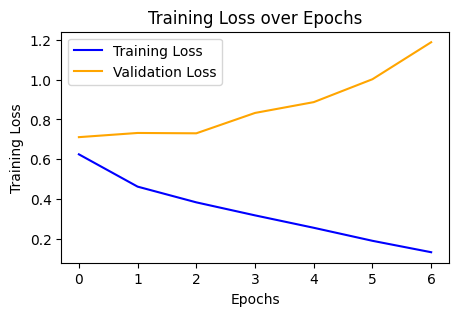

In [70]:
# Compare the losses of the two models
plt.figure(figsize=(5,3))
plt.plot(history['train_loss'], label='Training Loss', color='blue')
plt.plot(history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

## Model B: Transformer with Attention

In [71]:
class PositionalEncoding(nn.Module):
    def __init__(self,d_model,max_len = 512, dropout = 0.1):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0,max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0,d_model,2).float() * (-math.log(10000.0) / d_model))
        pe[:,0::2] = torch.sin(position * div_term) # For even dims
        pe[:,1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor):
        x = x + self.pe[:, :x.size(1), :] 
        return self.dropout(x)

In [72]:
class TransformerClassifier(nn.Module):
    def __init__(self, embedding_matrix, num_classes, n_heads, n_layers, dropout):
        super().__init__()
        vocab_size, embed_dim = embedding_matrix.shape
        self.d_model = embed_dim

        # Embedding Layer
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False, padding_idx=PAD_ID)

        # Positional Encoding
        self.pos_encoder = PositionalEncoding(embed_dim, max_len=MAX_SEQ_LEN, dropout=dropout)

        # Transformer Encoder Layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=n_heads,
            dropout=dropout,
            dim_feedforward=256,
            batch_first=True # Makes working with batch dimension easier
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer,num_layers=n_layers)

        # Final Classification Head
        self.classifier = nn.Linear(embed_dim,num_classes)

    def forward(self, src, src_mask):
        padding_mask = (src_mask == 0)

        # Apply embedding and positional encoding
        embedded = self.embedding(src) * math.sqrt(self.d_model)
        pos_encoded = self.pos_encoder(embedded)

        # Pass trough the transformer encoder
        encoded = self.transformer_encoder(pos_encoded,src_key_padding_mask = padding_mask)

        # Use the output of the [CLS] token (first token) for classification
        cls_output = encoded[:,0,:]

        # Get final logits from the classifier
        logits = self.classifier(cls_output)
        return logits

In [73]:
# Transformer Hyperparameters
N_HEADS = 8
N_LAYERS = 4
DROPOUT = 0.5
NUM_CLASSES = 2
LR = 0.0002
WD = 0.2
NUM_EPOCHS = 50

# Now, instantiate the model
transformer_model = TransformerClassifier(
    embedding_matrix=embedding_matrix,
    num_classes=NUM_CLASSES,
    n_heads=N_HEADS,
    n_layers=N_LAYERS,
    dropout=DROPOUT
)


transformer_model.to(device)
optimizer = torch.optim.AdamW(transformer_model.parameters(), lr = LR, weight_decay=WD)


model, history = train_model(transformer_model, train_loader, valid_loader, optimizer, n_epochs=10, patience=3)

c:\Users\Josh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


Epoch 1/10 - Train loss: 0.6689, Train acc: 0.6131 - Val loss: 0.8168, Val acc: 0.5442
Epoch 2/10 - Train loss: 0.6349, Train acc: 0.6444 - Val loss: 0.7394, Val acc: 0.5711
Epoch 3/10 - Train loss: 0.6168, Train acc: 0.6654 - Val loss: 0.7314, Val acc: 0.5980
Epoch 4/10 - Train loss: 0.6036, Train acc: 0.6786 - Val loss: 0.7137, Val acc: 0.6188
Epoch 5/10 - Train loss: 0.5907, Train acc: 0.6914 - Val loss: 0.7907, Val acc: 0.5949
Epoch 6/10 - Train loss: 0.5815, Train acc: 0.7001 - Val loss: 0.7846, Val acc: 0.5872
Epoch 7/10 - Train loss: 0.5733, Train acc: 0.7087 - Val loss: 0.8575, Val acc: 0.5796
Early stopping triggered.


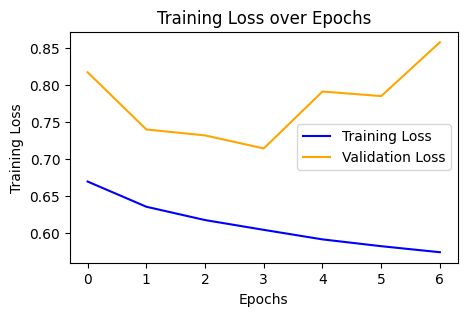

In [74]:
# Compare the losses of the two models
plt.figure(figsize=(5,3))
plt.plot(history['train_loss'], label='Training Loss', color='blue')
plt.plot(history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

## Model C: Encoder-Decoder with Attention

In [86]:
def prepare_pair_data_from_df(df, word2id, max_len_prem, max_len_hyp):
    PAD = word2id['[PAD]']
    UNK = word2id['[UNK]']
    label_map = {'neutral': 0, 'entails': 1}

    prem_ids, prem_mask, hyp_ids, hyp_mask, labels = [], [], [], [], []
    for _, row in df.iterrows():
        p = [word2id.get(w, UNK) for w in row['premise']][:max_len_prem]
        h = [word2id.get(w, UNK) for w in row['hypothesis']][:max_len_hyp]
        pm = [1]*len(p); hm=[1]*len(h)
        if len(p) < max_len_prem:
            p += [PAD]*(max_len_prem-len(p)); pm += [0]*(max_len_prem-len(pm))
        if len(h) < max_len_hyp:
            h += [PAD]*(max_len_hyp-len(h)); hm += [0]*(max_len_hyp-len(hm))
        prem_ids.append(p); prem_mask.append(pm)
        hyp_ids.append(h);  hyp_mask.append(hm)
        labels.append(label_map[row['label']])

    return (torch.LongTensor(prem_ids),
            torch.LongTensor(prem_mask),
            torch.LongTensor(hyp_ids),
            torch.LongTensor(hyp_mask),
            torch.LongTensor(labels))

xp_train, mp_train, xh_train, mh_train, _ = prepare_pair_data_from_df(clean_train_dataset, word2id, MAX_SEQ_LEN//2, MAX_SEQ_LEN//2)
xp_test,  mp_test,  xh_test,  mh_test,  _ = prepare_pair_data_from_df(clean_test_dataset,  word2id, MAX_SEQ_LEN//2, MAX_SEQ_LEN//2)
xp_valid,  mp_valid,  xh_valid,  mh_valid,  _ = prepare_pair_data_from_df(clean_validation_dataset,  word2id, MAX_SEQ_LEN//2, MAX_SEQ_LEN//2)


In [98]:
class AdditiveAttention(nn.Module):
    def __init__(self, enc_dim, dec_dim, attn_dim):
        super().__init__()
        self.W_e = nn.Linear(enc_dim, attn_dim, bias=False)
        self.W_d = nn.Linear(dec_dim, attn_dim, bias=False)
        self.v   = nn.Linear(attn_dim, 1, bias=False)

    def forward(self, enc_out, enc_mask, dec_state):
        """
        enc_out: (B, T_enc, enc_dim)
        enc_mask: (B, T_enc) with 1=real, 0=pad
        dec_state: (B, dec_dim)
        returns context (B, enc_dim) and attn weights (B, T_enc)
        """
        B, T, H = enc_out.size()
        # (B, T, attn_dim) + (B, 1, attn_dim) -> (B, T, attn_dim)
        scores = self.v(torch.tanh(self.W_e(enc_out) + self.W_d(dec_state).unsqueeze(1))).squeeze(-1)  # (B, T)
        # mask padded encoder positions
        mask = (enc_mask == 0)
        scores = scores.masked_fill(mask, -1e9)
        alpha = torch.softmax(scores, dim=1)                         # (B, T)
        ctx = torch.bmm(alpha.unsqueeze(1), enc_out).squeeze(1)      # (B, enc_dim)
        return ctx, alpha


class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, pad_idx, num_layers=1, dropout=0.1, bidir=True):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.gru = nn.GRU(emb_dim, hid_dim, num_layers=num_layers, batch_first=True,
                          dropout=dropout if num_layers > 1 else 0.0, bidirectional=bidir)
        self.bidir = bidir
        self.hid_dim = hid_dim
    def forward(self, x, mask):
        # lengths for packing
        lengths = mask.sum(dim=1).cpu()
        emb = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(emb, lengths, batch_first=True, enforce_sorted=False)
        packed_out, h = self.gru(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)  # (B, T, H*dir)
        return out, h

    def output_dim(self):
        return self.hid_dim * (2 if self.bidir else 1)


class DecoderWithAttention(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, pad_idx, enc_out_dim, attn_dim=128,
                 num_layers=1, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.gru = nn.GRU(emb_dim + enc_out_dim, hid_dim, num_layers=num_layers,
                          batch_first=True, dropout=dropout if num_layers>1 else 0.0)
        self.attn = AdditiveAttention(enc_out_dim, hid_dim, attn_dim)
        self.hid_dim = hid_dim

    def forward(self, hyp_ids, hyp_mask, enc_out, enc_mask, h0=None):
        """
        Run a single-pass decoder over the whole hypothesis with attention at each step.
        Returns final hidden state and (optional) attention maps.
        """
        B, Th = hyp_ids.size()
        emb = self.embedding(hyp_ids)  # (B, Th, E)
        # initialize hidden
        if h0 is None:
            h = torch.zeros(1, B, self.hid_dim, device=hyp_ids.device)
        else:
            h = h0
        outputs = []
        # step through time (simple & clear; fast enough for typical lengths)
        for t in range(Th):
            dec_state = h[-1]  # (B, H)
            ctx, _ = self.attn(enc_out, enc_mask, dec_state)  # (B, enc_dim)
            x_t = torch.cat([emb[:, t, :], ctx], dim=1).unsqueeze(1)  # (B,1,E+enc_dim)
            out_t, h = self.gru(x_t, h)  # out_t: (B,1,H)
            outputs.append(out_t)
        dec_outputs = torch.cat(outputs, dim=1)  # (B, Th, H)

        # take masked mean of decoder outputs as sequence representation
        hyp_mask_float = hyp_mask.float().unsqueeze(-1)  # (B, Th, 1)
        summed = (dec_outputs * hyp_mask_float).sum(dim=1)  # (B, H)
        denom = hyp_mask_float.sum(dim=1).clamp_min(1.0)
        pooled = summed / denom
        return pooled, h

class EncDecNLI(nn.Module):
    def __init__(self, vocab_size, pad_idx, emb_dim=200,
                 enc_hid=128, dec_hid=128, num_layers=1, dropout=0.1, bidir=True):
        super().__init__()
        self.encoder = Encoder(vocab_size, emb_dim, enc_hid, pad_idx, num_layers, dropout, bidir)
        self.decoder = DecoderWithAttention(vocab_size, emb_dim, dec_hid, pad_idx,
                                            enc_out_dim=self.encoder.output_dim(), attn_dim=128,
                                            num_layers=1, dropout=dropout)
        fusion_in = self.encoder.output_dim() + dec_hid
        self.classifier = nn.Sequential(
            nn.Linear(fusion_in, fusion_in),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fusion_in, 1)  # binary logit
        )

    def forward(self, prem_ids, prem_mask, hyp_ids, hyp_mask):
        enc_out, _ = self.encoder(prem_ids, prem_mask)                # (B, Tp, He)
        hyp_repr, _ = self.decoder(hyp_ids, hyp_mask, enc_out, prem_mask)  # (B, Hd)
        # mean-pool encoder outputs
        prem_mask_f = prem_mask.float().unsqueeze(-1)
        enc_pooled = (enc_out * prem_mask_f).sum(dim=1) / prem_mask_f.sum(dim=1).clamp_min(1.0)
        fused = torch.cat([enc_pooled, hyp_repr], dim=1)
        logit = self.classifier(fused).squeeze(1)  # (B,)
        return logit

In [99]:
def binary_accuracy_from_logits(logits, labels):
    preds = (torch.sigmoid(logits) >= 0.5).long()
    correct = (preds == labels.long()).sum().item()
    return correct / labels.size(0)


def train_model(model, train_loader, val_loader, device, optimizer=None, epochs=10, patience=3, clip=1.0):
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
    criterion = nn.BCEWithLogitsLoss()

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    best_val = float('inf')
    best_state = None
    epochs_no_improve = 0

    model.to(device)
    criterion.to(device)

    for ep in range(1, epochs+1):
        # ---- train ----
        model.train()
        tot_loss, tot_correct, tot_count = 0.0, 0, 0
        for prem_ids, prem_mask, hyp_ids, hyp_mask, labels in train_loader:
            prem_ids = prem_ids.to(device)
            prem_mask = prem_mask.to(device)
            hyp_ids = hyp_ids.to(device)
            hyp_mask = hyp_mask.to(device)
            labels = labels.float().to(device)

            optimizer.zero_grad()
            logits = model(prem_ids, prem_mask, hyp_ids, hyp_mask)
            loss = criterion(logits, labels)
            loss.backward()
            if clip is not None:
                nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

            tot_loss += loss.item() * labels.size(0)
            tot_correct += (torch.sigmoid(logits).round().long() == labels.long()).sum().item()
            tot_count += labels.size(0)

        train_loss = tot_loss / tot_count
        train_acc = tot_correct / tot_count

        # ---- eval ----
        model.eval()
        v_loss, v_correct, v_count = 0.0, 0, 0
        with torch.no_grad():
            for prem_ids, prem_mask, hyp_ids, hyp_mask, labels in val_loader:
                prem_ids = prem_ids.to(device)
                prem_mask = prem_mask.to(device)
                hyp_ids = hyp_ids.to(device)
                hyp_mask = hyp_mask.to(device)
                labels_f = labels.float().to(device)

                logits = model(prem_ids, prem_mask, hyp_ids, hyp_mask)
                loss = criterion(logits, labels_f)

                v_loss += loss.item() * labels.size(0)
                v_correct += (torch.sigmoid(logits).round().long() == labels.long().to(device)).sum().item()
                v_count += labels.size(0)

        val_loss = v_loss / v_count
        val_acc = v_correct / v_count

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {ep:02d} | train loss {train_loss:.4f} acc {train_acc:.4f} | "
              f"val loss {val_loss:.4f} acc {val_acc:.4f}")

        # early stopping
        if val_loss < best_val - 1e-6:
            best_val = val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {ep} (no improvement for {patience} epochs).")
                break

    # load best
    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history

In [ ]:
# Build loaders
train_ds = TensorDataset(xp_train, mp_train, xh_train, mh_train, y_train)
valid_ds = TensorDataset(xp_valid,  mp_valid,  xh_valid,  mh_valid, y_valid)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(valid_ds, batch_size=BATCH_SIZE)

# Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vocab_size = len(word2id)
pad_idx = word2id['[PAD]']
model = EncDecNLI(vocab_size=vocab_size, pad_idx=pad_idx,
                  emb_dim=200, enc_hid=128, dec_hid=128, dropout=0.2, bidir=True)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)

# Train for 10 epochs with early stopping
model, history = train_model(model, train_loader, val_loader, device, optimizer=optimizer, epochs=10, patience=3, clip=1.0)

print("History:", history)

RuntimeError: The size of tensor a (32) must match the size of tensor b (24) at non-singleton dimension 1

# 3.Testing and Evaluation


In [ ]:
# TODO cleanup encoder-decoder
# TODO hyperparameter optimisation (additional ablation study)
# TODO Attention ablation study
# TODO final model evaluations and comparison
# TODO qualitative analysis of attention